Task 1

Pandas is used to process The fake news corpus. Since content will be used for our models we drop any rows that don't have any content.

In [3]:
# Import standard libraries and set up NLTK resources
import re
import time
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cleantext import clean

# Download necessary NLTK datasets (only run once)
nltk.download('punkt')
nltk.download('stopwords')

# Define text processing functions
def clean_text(text):
    """Clean text by replacing dates, URLs, emails, numbers, etc."""
    text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
    cleaned = clean(text,
                    lower=True,
                    no_urls=True, replace_with_url="<URL>",
                    no_emails=True, replace_with_email="<EMAIL>",
                    no_numbers=True, replace_with_number="<NUM>",
                    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
                    no_punct=True, replace_with_punct="",
                    no_line_breaks=True)
    return cleaned

def rmv_stopwords(tokens):
    """Remove English stopwords from a list of tokens."""
    stop_words = set(nltk.corpus.stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def stem_tokens(tokens):
    """Apply Porter stemming to a list of tokens."""
    stemmer = nltk.PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

def build_vocabulary(token_lists):
    """Build a vocabulary Counter from a list of token lists."""
    tokens = []
    for lst in token_lists:
        tokens.extend(lst)
    return Counter(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We've implemented data processing functions to do the following:

    - Clean the text
    - Tokenize the text
    - Remove stopwords
    - Remove word variations with stemming
We use nltk and cleantext because it has built-in support for many of these operations.
We also use collections to import a counter, sklearn to import functions to split the dataset, chain to help with counting and matplotlib for visualizing.

In [4]:
# Read the sample dataset and drop rows without content
df = pd.read_csv("Datasets/news_sample.csv")
df = df.dropna(subset=['content']).copy()
print(f"Initial dataset shape: {df.shape}")


Initial dataset shape: (250, 16)


Task 2

We apply our data processing pipeline from task 1 on the 995k FakeNewsCorpus.

Since Pandas is slow on larger datasets we can use modin and ray to optimize pandas and allow for multithreading.

In [5]:
from nltk.tokenize.regexp import RegexpTokenizer

# Clean the content column
df['content'] = df['content'].apply(clean_text)

# Tokenize the cleaned text using a regular expression tokenizer
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
df["tokenized"] = df.content.apply(tokenizer.tokenize)

# Build and print vocabulary size after cleaning
vocab = build_vocabulary(df.tokenized)
print("After cleaning:")
print(f"Vocabulary size: {len(vocab)}")


After cleaning:
Vocabulary size: 16594


In [6]:
# Remove stopwords and recalculate vocabulary size
df["tokenized"] = df.tokenized.apply(rmv_stopwords)
vocab_before = build_vocabulary(df.tokenized)
reduction_rate = ((len(vocab) - len(vocab_before)) / len(vocab)) * 100
print("\nAfter removing stopwords:")
print(f"Vocabulary size: {len(vocab_before)}")
print(f"Reduction rate: {reduction_rate:.2f}%")

# Apply stemming and calculate vocabulary reduction
df["tokenized"] = df.tokenized.apply(stem_tokens)
vocab_after = build_vocabulary(df.tokenized)
reduction_rate = ((len(vocab_before) - len(vocab_after)) / len(vocab_before)) * 100
print("\nAfter stemming:")
print(f"Vocabulary size: {len(vocab_after)}")
print(f"Reduction rate: {reduction_rate:.2f}%")



After removing stopwords:
Vocabulary size: 16462
Reduction rate: 0.80%

After stemming:
Vocabulary size: 11048
Reduction rate: 32.89%


In [ ]:
# Use Modin (with Ray engine) for large-scale data processing
import modin.config as modin_cfg
modin_cfg.Engine.put("ray")
import modin.pandas as mpd

# Read only needed columns and drop rows with missing values
df_large = mpd.read_csv("Datasets/995000_rows.csv", 
                        usecols=['content', 'type', 'title', 'domain'],
                        engine='c', dtype=str)
df_large = df_large.dropna(subset=['content', 'type', 'title']).copy()

# Clean text in title and content and measure time
start = time.time()
df_large['title'] = df_large.title.apply(clean_text)
df_large['content'] = df_large.content.apply(clean_text)
print(f"Time to clean the data: {time.time() - start:.2f} sec")

# Tokenization
start = time.time()
df_large['title'] = df_large.title.apply(tokenizer.tokenize)
df_large['content'] = df_large.content.apply(tokenizer.tokenize)
print(f"Time to tokenize the data: {(time.time() - start)/60:.2f} min")

# Remove stopwords
start = time.time()
df_large['title'] = df_large.title.apply(rmv_stopwords)
df_large['content'] = df_large.content.apply(rmv_stopwords)
print(f"Time to remove stopwords: {(time.time() - start)/60:.2f} min")

# Apply stemming
start = time.time()
df_large['title'] = df_large.title.apply(stem_tokens)
df_large['content'] = df_large.content.apply(stem_tokens)
print(f"Time to stem the data: {(time.time() - start):.2f} sec")


Numerics in content: 7510905
Numerics in titles: 170851


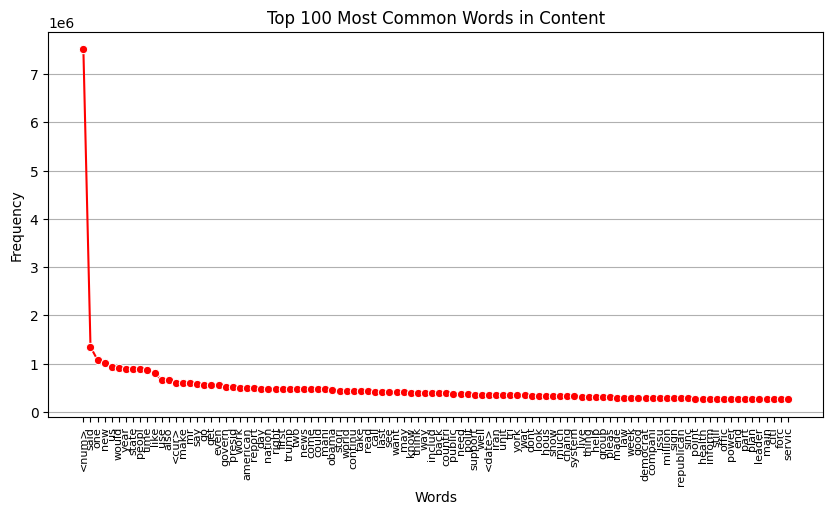

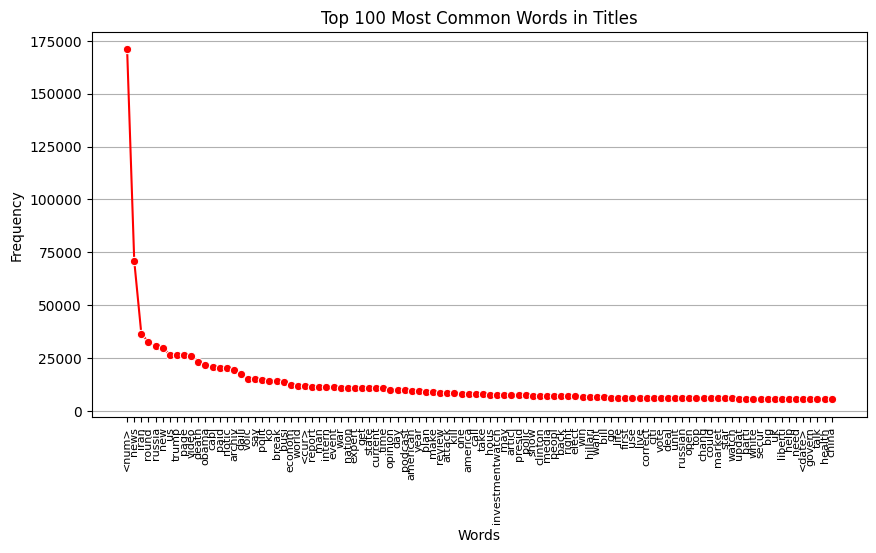

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


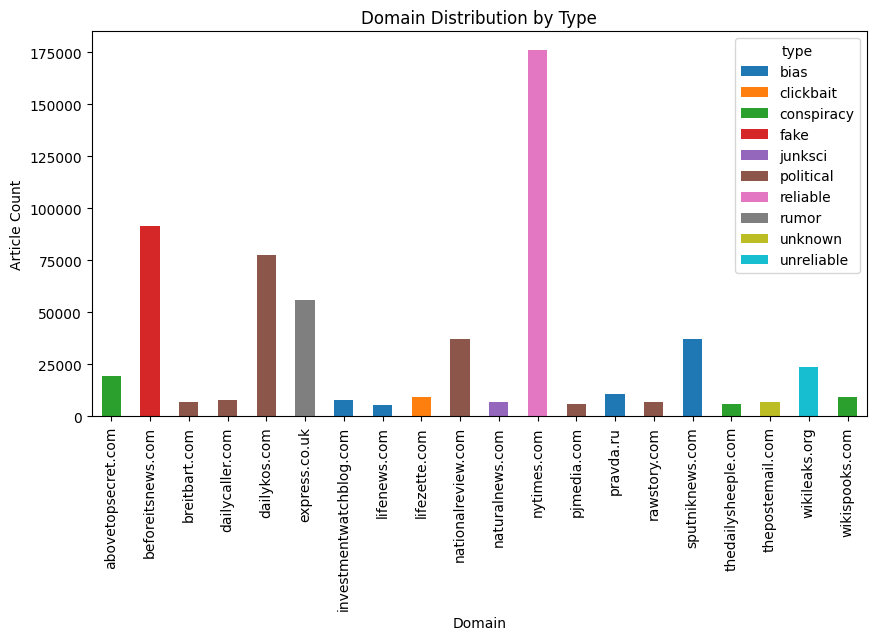

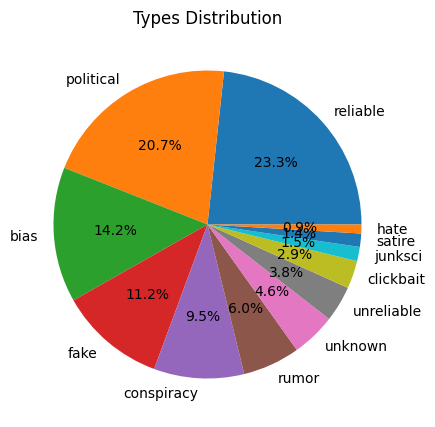

Number of dropped rows: 56368


Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


In [ ]:
# Define plotting functions
def plot_freq(counter, top_n, title):
    """Plot frequency distribution for the top_n words."""
    common = counter.most_common(top_n)
    words, freqs = zip(*common)
    
    plt.figure(figsize=(max(8, top_n * 0.1), 5))
    sns.lineplot(x=list(words), y=list(freqs), color='red', marker='o')
    plt.xticks(rotation=90, fontsize=8)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

def plot_domain_with_type(df):
    """Plot the distribution of article types for the top 20 domains."""
    top_domains = df['domain'].value_counts().head(20).index
    df_subset = df[df.domain.isin(top_domains)]
    df_grouped = df_subset.groupby(['domain', 'type']).size().unstack(fill_value=0)
    df_grouped.plot(kind='bar', stacked=True, figsize=(10,5), title='Domain Distribution by Type')
    plt.xlabel('Domain')
    plt.ylabel('Article Count')
    plt.show()

# Build vocabularies for content and title (using original tokenized lists)
vocab_content = build_vocabulary(df_large.content)
vocab_title = build_vocabulary(df_large.title)
print("Numerics in content:", vocab_content.get("<num>", 0))
print("Numerics in titles:", vocab_title.get("<num>", 0))

# Plot the top 100 most frequent words in content and title
plot_freq(vocab_content, 100, "Top 100 Most Common Words in Content")
plot_freq(vocab_title, 100, "Top 100 Most Common Words in Titles")

# Plot domain distribution and article type
plot_domain_with_type(df_large)

# Plot the overall distribution of article types
plt.figure(figsize=(8,5))
df_large['type'].value_counts().plot.pie(autopct='%1.1f%%', title='Types Distribution')
plt.ylabel('')
plt.show()

# Print number of dropped rows
# (Assuming df_large was the result after dropping rows from the original dataset)
print(f"Number of dropped rows: {mpd.read_csv('Datasets/995000_rows.csv').shape[0] - df_large.shape[0]}")


In [ ]:
# Re-join token lists into strings for saving
df_large['content'] = df_large.content.apply(lambda tokens: ' '.join(tokens))
df_large['title'] = df_large.title.apply(lambda tokens: ' '.join(tokens))

# Export the cleaned dataset to CSV
df_large.to_csv('Datasets/995k_rows_cleaned.csv', index=False)
print("Data cleaning and export completed.")

# Shutdown Ray to free memory
import ray
ray.shutdown()


Data cleaning and export completed.


In [ ]:
from sklearn.model_selection import train_test_split

# Load cleaned dataset with selected columns
df_clean = pd.read_csv('Datasets/995k_rows_cleaned.csv', usecols=['content', 'type', 'title'], dtype=str).dropna()

# Map article types to binary labels (1: fake-related, 0: reliable)
type_mapping = {'fake': 1, 'conspiracy': 1, 'junksci': 1, 'bias': 1, 
                'clickbait': 0, 'political': 0, 'reliable': 0}
df_clean['label'] = df_clean['type'].map(type_mapping)
df_clean = df_clean.dropna(subset=['label'])
df_clean['label'] = df_clean['label'].astype(int)

# Drop rows with missing content or title
df_clean = df_clean.dropna(subset=['content', 'title'])

# Split into training (80%), validation (10%), and test (10%) sets using stratification
train_df, temp_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['label'])
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# Extract features and labels for further use
content_train, title_train, y_train = train_df['content'], train_df['title'], train_df['label']
content_val, title_val, y_val = validation_df['content'], validation_df['title'], validation_df['label']
content_test, title_test, y_test = test_df['content'], test_df['title'], test_df['label']

print("Training set (content sample):")
print(content_train.head())
print("\nTraining set (title sample):")
print(title_train.head())


Training set (content sample):
225372    queri depth predefin properti inform depth num...
572701    origin post apc sweet scari anyon rejoic murde...
223899    tom aue <num> got surpris life paus moment sal...
130930    handl invas speci studi look treatment commerc...
163074    let us walk white snow soundless space footste...
Name: content, dtype: object

Training set (title sample):
225372                                      benton k partin
572701    gunman kill <num> missionari train center page...
223899    veteran salut american flag ballgam happen nex...
130930    handl invas speci studi look treatment commerc...
163074      classic poetri snow day velvet shoe elinor wyli
Name: title, dtype: object


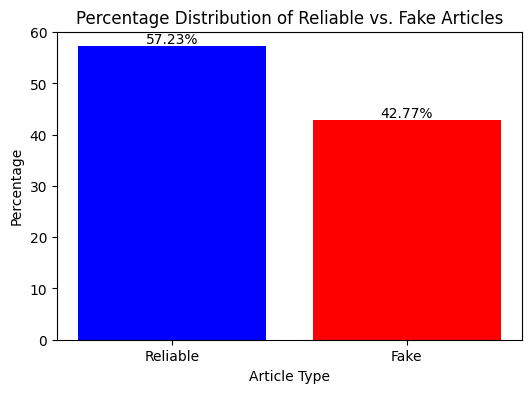

In [ ]:
# Calculate percentage distribution
type_distribution = df_clean['label'].value_counts(normalize=True) * 100

# Bar plot of reliable vs. fake article percentages
plt.figure(figsize=(6,4))
bars = plt.bar([0, 1], type_distribution, tick_label=['Reliable', 'Fake'], color=['blue', 'red'])
for bar, pct in zip(bars, type_distribution):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct:.2f}%', ha='center', va='bottom')
plt.xlabel('Article Type')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Reliable vs. Fake Articles')
plt.show()


In [20]:
# Load extra reliable articles scraped from BBC
df_extra = pd.read_csv("Datasets/bbc_article_details.csv", usecols=['content']).dropna()

# Process the extra articles similarly
df_extra['content'] = df_extra['content'].apply(clean_text)
df_extra['content'] = df_extra['content'].apply(tokenizer.tokenize)
df_extra['content'] = df_extra['content'].apply(rmv_stopwords)
df_extra['content'] = df_extra['content'].apply(stem_tokens)
df_extra['label'] = 0  # reliable articles labeled as 0

# Convert tokens back to strings
df_extra['content'] = df_extra['content'].apply(lambda tokens: ' '.join(tokens))

# Append extra reliable articles to training data
content_train_extra = pd.concat([content_train, df_extra['content']], ignore_index=True)
y_train_extra = pd.concat([y_train, df_extra['label']], ignore_index=True)


In [21]:
from sklearn import metrics

def make_confusion_matrix(y_true, y_pred, model_name):
    """Plot a confusion matrix using seaborn heatmap."""
    cm = metrics.confusion_matrix(y_true, y_pred, labels=[1, 0])
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(model_name)
    plt.show()


In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from joblib import dump

# Build a pipeline for bag-of-words feature extraction and scaling
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=False, max_features=5000, token_pattern=r'<[\w]+>|[\w]+')),
    ('scaler', StandardScaler(with_mean=False))
])

# Create bag-of-words representations for extra content and validation content
BoW_train_extra = bow_pipeline.fit_transform(content_train_extra)
BoW_val_content = bow_pipeline.transform(content_val)

# Train a simple logistic regression model using extra data (content only)
simple_model = LogisticRegression(max_iter=10000, random_state=42)
simple_model.fit(BoW_train_extra, y_train_extra)
y_pred_val = simple_model.predict(BoW_val_content)
print("Only content (with extra data):")
print("Accuracy:", metrics.accuracy_score(y_val, y_pred_val))
print("F1 score:", metrics.f1_score(y_val, y_pred_val))

# Now build BoW for training with only the original training data
BoW_train_content = bow_pipeline.fit_transform(content_train)
BoW_val_content = bow_pipeline.transform(content_val)

simple_model.fit(BoW_train_content, y_train)
y_pred_val = simple_model.predict(BoW_val_content)
print("\nOnly content:")
print("Accuracy:", metrics.accuracy_score(y_val, y_pred_val))
print("F1 score:", metrics.f1_score(y_val, y_pred_val))

# For combined content and title, create separate BoW representations and stack them
BoW_train_title = bow_pipeline.fit_transform(title_train)
BoW_val_title = bow_pipeline.transform(title_val)
BoW_combined_train = hstack((BoW_train_content, BoW_train_title))
BoW_combined_val = hstack((BoW_val_content, BoW_val_title))

simple_model.fit(BoW_combined_train, y_train)
y_pred_combined = simple_model.predict(BoW_combined_val)
print("\nContent and title:")
print("Accuracy:", metrics.accuracy_score(y_val, y_pred_combined))
print("F1 score:", metrics.f1_score(y_val, y_pred_combined))

# Save the simple model (combined version)
dump(simple_model, 'models/simple_model_combined.joblib')


Only content (with extra data):
Accuracy: 0.8454840805717999
F1 score: 0.8160126268878435

Only content:
Accuracy: 0.8457050032488629
F1 score: 0.8165510421656031

Content and title:
Accuracy: 0.8762573099415205
F1 score: 0.8525458374628345


['models/simple_model_combined.joblib']

In [23]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# --- Helper functions for model training ---
def train_svm(x_train, y_train, x_val, model_name):
    start_time = time.time()
    svc = LinearSVC(max_iter=10000, dual=False, random_state=42)
    params = {'C': [0.1, 1, 10, 20, 50, 100]}
    grid = GridSearchCV(svc, params, cv=3, n_jobs=-1, scoring='f1', pre_dispatch=3)
    grid.fit(x_train, y_train)
    print(f"SVM training time: {(time.time() - start_time)/60:.2f} min")
    print("Best Parameters for SVM:", grid.best_params_)
    dump(grid, f'models/{model_name}.joblib')
    return grid.predict(x_val)

def train_naive_bayes(x_train, y_train, x_val, model_name):
    start_time = time.time()
    nb = MultinomialNB()
    params = {'alpha': [0.01, 0.1, 1, 10]}
    grid = GridSearchCV(nb, params, cv=3, n_jobs=-1, scoring='f1')
    grid.fit(x_train, y_train)
    print(f"Naive Bayes training time: {(time.time() - start_time)/60:.2f} min")
    print("Best Parameters for Naive Bayes:", grid.best_params_)
    dump(grid, f'models/{model_name}.joblib')
    return grid.predict(x_val)

def train_logistic(x_train, y_train, x_val, model_name):
    start_time = time.time()
    logistic = LogisticRegression(max_iter=10000, random_state=42)
    params = {'C': [0.1, 1, 10], 'solver': ['sag', 'saga']}
    grid = GridSearchCV(logistic, params, cv=3, n_jobs=-1, scoring='f1', pre_dispatch=3)
    grid.fit(x_train, y_train)
    print(f"Logistic regression training time: {(time.time() - start_time)/3600:.2f} hours")
    print("Best Parameters for Logistic Regression:", grid.best_params_)
    dump(grid, f'models/{model_name}.joblib')
    return grid.predict(x_val)

# --- TF-IDF feature extraction function ---
from sklearn.feature_extraction.text import TfidfVectorizer

def make_TFIDF(features, ngrams):
    tfidf_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(lowercase=False, 
                                       max_features=features, 
                                       min_df=1, 
                                       max_df=0.9, 
                                       token_pattern=r'<[\w]+>|[\w]+',
                                       ngram_range=ngrams)),
        ('scaler', StandardScaler(with_mean=False))
    ])
    
    # Build TF-IDF for both content and title; then combine
    content_train_tfidf = tfidf_pipeline.fit_transform(content_train, y_train)
    content_val_tfidf   = tfidf_pipeline.transform(content_val)
    title_train_tfidf   = tfidf_pipeline.fit_transform(title_train, y_train)
    title_val_tfidf     = tfidf_pipeline.transform(title_val)
    
    X_train = hstack((content_train_tfidf, title_train_tfidf))
    X_val   = hstack((content_val_tfidf, title_val_tfidf))
    return X_train, X_val

# --- Evaluate advanced models using TF-IDF (1-gram) ---
X_train_tfidf, X_val_tfidf = make_TFIDF(3500, (1, 1))

print("Evaluating SVM with TF-IDF (1-gram):")
y_pred_svm = train_svm(X_train_tfidf, y_train, X_val_tfidf, 'svm_1gram')
print("SVM F1 score:", metrics.f1_score(y_val, y_pred_svm))
print("SVM Accuracy:", metrics.accuracy_score(y_val, y_pred_svm))

print("\nEvaluating Logistic Regression with TF-IDF (1-gram):")
y_pred_logistic = train_logistic(X_train_tfidf, y_train, X_val_tfidf, 'logistic_1gram')
print("Logistic Regression F1 score:", metrics.f1_score(y_val, y_pred_logistic))
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_val, y_pred_logistic))

print("\nEvaluating Naive Bayes with TF-IDF (1-gram):")
y_pred_nb = train_naive_bayes(X_train_tfidf, y_train, X_val_tfidf, 'naive_bayes_1gram')
print("Naive Bayes F1 score:", metrics.f1_score(y_val, y_pred_nb))
print("Naive Bayes Accuracy:", metrics.accuracy_score(y_val, y_pred_nb))

# --- Repeat for TF-IDF with 2-grams if desired ---
X_train_tfidf_2, X_val_tfidf_2 = make_TFIDF(3500, (2, 2))
print("\nEvaluating SVM with TF-IDF (2-gram):")
y_pred_svm_2 = train_svm(X_train_tfidf_2, y_train, X_val_tfidf_2, 'svm_2gram')
print("SVM (2-gram) F1 score:", metrics.f1_score(y_val, y_pred_svm_2))
print("SVM (2-gram) Accuracy:", metrics.accuracy_score(y_val, y_pred_svm_2))


Evaluating SVM with TF-IDF (1-gram):
SVM training time: 10.63 min
Best Parameters for SVM: {'C': 10}
SVM F1 score: 0.8600814820508879
SVM Accuracy: 0.8817283950617284

Evaluating Logistic Regression with TF-IDF (1-gram):
Logistic regression training time: 1.01 hours
Best Parameters for Logistic Regression: {'C': 10, 'solver': 'saga'}
Logistic Regression F1 score: 0.8611797192605661
Logistic Regression Accuracy: 0.8824041585445094

Evaluating Naive Bayes with TF-IDF (1-gram):
Naive Bayes training time: 0.08 min
Best Parameters for Naive Bayes: {'alpha': 0.01}
Naive Bayes F1 score: 0.792068208959369
Naive Bayes Accuracy: 0.8054061078622482

Evaluating SVM with TF-IDF (2-gram):
SVM training time: 6.79 min
Best Parameters for SVM: {'C': 20}
SVM (2-gram) F1 score: 0.8301075953396575
SVM (2-gram) Accuracy: 0.8612865497076023



Simple Model on Test Set:
Accuracy: 0.5310591293047433
F1 score: 0.4138334335049788


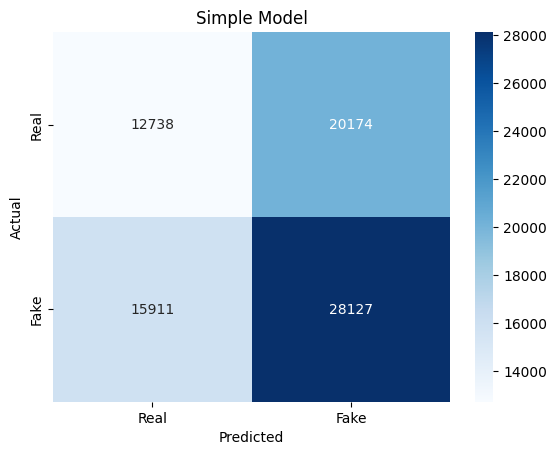


Advanced Model on Test Set:
Accuracy: 0.5051332033788174
F1 score: 0.4448979591836735


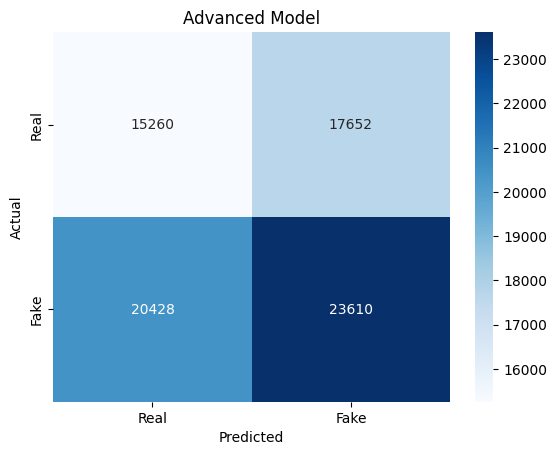

In [31]:
from joblib import load

# Load pre-trained simple and advanced models
simple_model_loaded = load('models/simple_model_combined.joblib')
advanced_model_loaded = load('models/svm_1gram.joblib')

# Build separate pipelines for BoW and TF-IDF feature extraction for testing
test_bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000, token_pattern=r'<[\w]+>|[\w]+')),
    ('scaler', StandardScaler(with_mean=False))
])
BoW_content_test = test_bow_pipeline.fit_transform(content_test)
BoW_title_test = test_bow_pipeline.fit_transform(title_test)
combined_test_bow = hstack((BoW_content_test, BoW_title_test))

# Evaluate the simple model
simple_pred_test = simple_model_loaded.predict(combined_test_bow)
print("\nSimple Model on Test Set:")
print("Accuracy:", metrics.accuracy_score(y_test, simple_pred_test))
print("F1 score:", metrics.f1_score(y_test, simple_pred_test))
make_confusion_matrix(y_test, simple_pred_test, "Simple Model")

# For advanced model using TF-IDF, build the corresponding pipeline
test_tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=False, 
                                   max_features=3500, 
                                   min_df=1, 
                                   max_df=0.9, 
                                   token_pattern=r'<[\w]+>|[\w]+',
                                   ngram_range=(1, 1))),
    ('scaler', StandardScaler(with_mean=False))
])
content_test_tfidf = test_tfidf_pipeline.fit_transform(content_test)
title_test_tfidf   = test_tfidf_pipeline.fit_transform(title_test)
combined_test_tfidf = hstack((content_test_tfidf, title_test_tfidf))

advanced_pred_test = advanced_model_loaded.predict(combined_test_tfidf)
print("\nAdvanced Model on Test Set:")
print("Accuracy:", metrics.accuracy_score(y_test, advanced_pred_test))
print("F1 score:", metrics.f1_score(y_test, advanced_pred_test))
make_confusion_matrix(y_test, advanced_pred_test, "Advanced Model")



Evaluation on LIAR dataset (Simple Model):
Accuracy: 0.889839970227019
F1 score: 0.8740782756664776


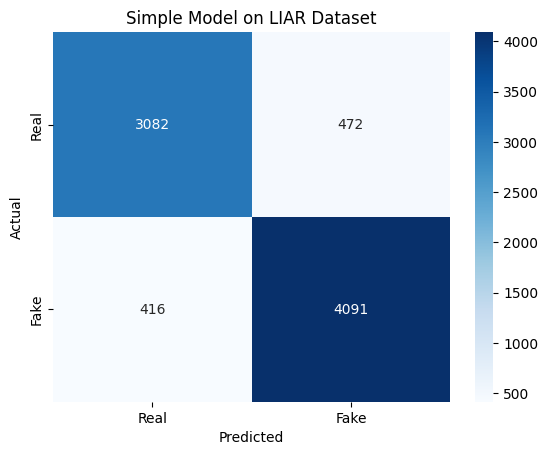


Evaluation on LIAR dataset (Advanced Model):
Accuracy: 0.524004465947153
F1 score: 0.4246513720197931


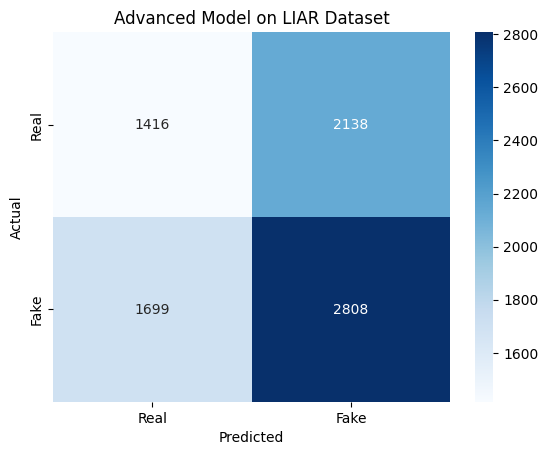

In [33]:
# Load LIAR dataset splits and concatenate them
liar_train = pd.read_csv('Datasets/train.tsv', sep='\t', header=None)
liar_val   = pd.read_csv('Datasets/valid.tsv', sep='\t', header=None)
liar_test  = pd.read_csv('Datasets/test.tsv', sep='\t', header=None)
liar_df = pd.concat([liar_train, liar_val, liar_test], ignore_index=True)

# Process the LIAR dataset (assume column 2 contains text)
liar_df[2] = liar_df[2].apply(clean_text)
liar_df[2] = liar_df[2].apply(tokenizer.tokenize)
liar_df[2] = liar_df[2].apply(rmv_stopwords)
liar_df[2] = liar_df[2].apply(stem_tokens)
liar_df[2] = liar_df[2].apply(lambda tokens: ' '.join(tokens))

# Filter for used labels and map to binary (example mapping)
labels_used = ['pants-fire', 'false', 'mostly-true', 'true']
liar_df = liar_df.dropna(subset=[1])
liar_df = liar_df[liar_df[1].isin(labels_used)]
liar_df[1] = liar_df[1].map({'pants-fire': 1, 'false': 1, 'mostly-true': 0, 'true': 0})
liar_df = liar_df.dropna(subset=[2])

# Build pipelines for LIAR evaluation with limited features (7000 combined)
liar_bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=3500, token_pattern=r'<[\w]+>|[\w]+')),
    ('scaler', StandardScaler(with_mean=False))
])
# For combined features, create for content and title (here we use only column 2 as text)
liar_features = liar_df[2]
y_liar = liar_df[1]

liar_bow = liar_bow_pipeline.fit_transform(liar_features, y_liar)
# Train a simple logistic regression on LIAR (or load your adapted model)
simple_model_liar = LogisticRegression(max_iter=10000, random_state=42)
simple_model_liar.fit(liar_bow, y_liar)
simple_pred_liar = simple_model_liar.predict(liar_bow)

print("\nEvaluation on LIAR dataset (Simple Model):")
print("Accuracy:", metrics.accuracy_score(y_liar, simple_pred_liar))
print("F1 score:", metrics.f1_score(y_liar, simple_pred_liar))
make_confusion_matrix(y_liar, simple_pred_liar, "Simple Model on LIAR Dataset")

# For advanced model evaluation on LIAR using TF-IDF
liar_tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=False, 
                                   max_features=7000, 
                                   min_df=1, 
                                   max_df=0.9, 
                                   token_pattern=r'<[\w]+>|[\w]+',
                                   ngram_range=(1, 1))),
    ('scaler', StandardScaler(with_mean=False))
])
liar_tfidf = liar_tfidf_pipeline.fit_transform(liar_features, y_liar)

# Assuming advanced_model_loaded (e.g. a SVM trained with TF-IDF) is compatible
advanced_pred_liar = advanced_model_loaded.predict(liar_tfidf)
print("\nEvaluation on LIAR dataset (Advanced Model):")
print("Accuracy:", metrics.accuracy_score(y_liar, advanced_pred_liar))
print("F1 score:", metrics.f1_score(y_liar, advanced_pred_liar))
make_confusion_matrix(y_liar, advanced_pred_liar, "Advanced Model on LIAR Dataset")
